# Active Learning Meetup

Autor: Luiz Matias

29 de outubro de 2020

Nesse exemplo, vamos utilizar o dataset 20 newsgroups que é um problema de classificação de texto. Para simplificar, vamos utilizar somente três classes: Baseball, Hockey e Motorcycles. Para saber mais sobre esse dataset:  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html

### Importando Bibliotecas

In [1]:
from sklearn.datasets import fetch_20newsgroups
from modAL.uncertainty import uncertainty_sampling
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import __init__
from src.preprocessing_functions import clean_text
from src.plot_functions import plot_density_distribution, plot_dimensionality_reduction_distribution, plot_performance

Criando os dados brutos e de teste. Vamos comparar a estratégia de amostra de incerteza com a amostra aleatória na base de teste.

In [2]:
categories = ['rec.sport.baseball', 'rec.sport.hockey', 'rec.motorcycles'] 
twenty_raw = fetch_20newsgroups(subset= 'train', categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

Criando o dataset com a feature textual e a target. 

In [3]:
raw_data = pd.DataFrame(twenty_raw.data, columns=['Text'])
raw_data['target'] = twenty_raw.target
test_data = pd.DataFrame(twenty_test.data, columns=['Text'])
test_data['target'] = twenty_test.target

Limpando os dados textuais. Retirando stop words, dados númericos, caracteres indesejados e colocando tudo minúsculo

In [4]:
%%time
raw_data['text_clean'] = list(map(clean_text, raw_data['Text'].fillna('')))
test_data['text_clean'] = list(map(clean_text, test_data['Text'].fillna('')))

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.24 s


In [5]:
raw_data.head()

,Text,target,text_clean
0,"Posted for a friend:\n\nLooking for tires, dim...",0,posted friend looking tires dimensions also lo...
1,\na lot of batters lean in when pitches come. ...,1,lot batters lean pitches come rickey crouch te...
2,"\nI tell you, Steve Stone is like a prophet.\n...",1,tell steve stone like prophet must making ton ...
3,\nTheir phone number is 1-800-377-9777. The la...,1,phone number last catalog shows three oaks jer...
4,"\n\nAnd some comments, with some players delet...",1,comments players deleted yep kevin mitchell ne...


retirando linhas vazias

In [6]:
raw_data =  raw_data[(raw_data['text_clean'] != '') & (raw_data['text_clean'] != ' ')].reset_index(drop=True)
test_data =  test_data[(test_data['text_clean'] != '') & (test_data['text_clean'] != ' ')].reset_index(drop=True)

In [7]:
raw_data.target.value_counts()

2    584
0    583
1    572
Name: target, dtype: int64

Separando o dataset bruto em dados de base e dados pool. Os dados pool é a simulação dos dados não rotulados. Dados de base são os dados rotulados. Vamos ter, inicialmente, apenas 5% de dados rotulados!

In [8]:
df_base, df_pool = train_test_split(raw_data, test_size= 0.95, random_state=42)

Podemos notar que as classes estão balanceadas

In [9]:
df_base.target.value_counts()

0    33
1    29
2    24
Name: target, dtype: int64

In [10]:
df_pool.target.value_counts()

2    560
0    550
1    543
Name: target, dtype: int64

Analisando a distribuição dos dados de base em um espaço vetorial bidimensional. Foi utilizado o SVD truncado, nesse contexto é conhecido como LSA. Este transformador realiza a redução da dimensionalidade linear por meio da decomposição de valor singular truncado (SVD). Ao contrário do PCA, este estimador não centraliza os dados antes de calcular a decomposição de valor singular. Isso significa que ele pode trabalhar com matrizes esparsas de forma eficiente. Saiba mais: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

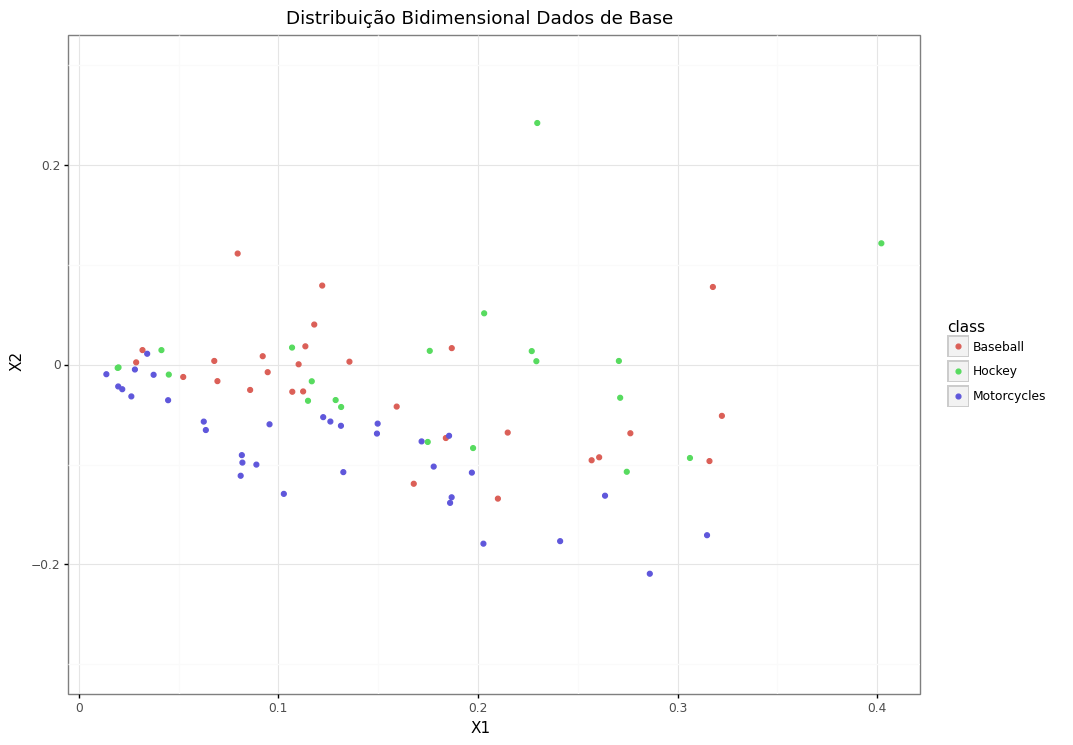

In [11]:
plot_dimensionality_reduction_distribution(df_base.text_clean, df_base.target, 'Distribuição Bidimensional Dados de Base')

Criando o pipeline do nosso modelo. Vamos utilizar o TfidfVectorizer para converter os dados textuais em uma matriz TF-IDF (saiba mais: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) e usar um modelo de classificação SVM. Nele, é preciso habilitar o hiperparâmetro "probability" para que ele possa criar as estimativas de probabilidade. E foi colocado o hiperparâmetro "class_weight" para balanceado. Isso utiliza a quantidade das classes para ajustar automaticamente os pesos inversamente proporcional às frequências da classe. (saiba mais https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [12]:
model = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('SVM', SVC(probability=True, random_state=42, class_weight='balanced'))
])

Separando nossa feature textual e o target nos nossos dados de base

In [13]:
X_base = df_base.text_clean
y_base = df_base.target

Separando nossa feature textual e o target nos nossos dados de teste

In [14]:
X_test = test_data.text_clean
y_test = test_data.target

Treinando o modelo para ver o quanto de acurácia inicial teremos nos dados de teste. 

In [15]:
model.fit(X_base, y_base)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SVM',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [16]:
first_accuracy = np.round(model.score(X_test, y_test), 4)
first_accuracy

0.636

Vamos criar uma lista com os dados de base. A medida que as instâncias forem sendo escolhidas e rotuladas, vamos alimentando essas listas.

In [17]:
X_list_base = []
y_list_base = []
X_list_base += df_base.text_clean.tolist()
y_list_base += df_base.target.tolist()

### Estratégia utilizada: amostragem de incerteza
**modAL.uncertainty.uncertainty_sampling()**

Estratégia de consulta de amostragem de incerteza. Seleciona as instâncias menos seguras para rotulagem.

**Parameters**:	

**classifier** – O classificador

**X** – A amostra de pool para ser rotulada

**n_instances** – Quantas instâncias para serem rotuladas

**Retorna:**	

Os índices das instâncias de X escolhidas para serem rotuladas; as instâncias de X escolhidas para serem rotuladas.

source: https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html

Vamos repetir o processo de rotulação 35 vezes. Cada amostra terão 5 instâncias novas. Essas instâncias serão inseridas na lista de dados de base e retiradas dos dados de pool (dados não rotulados). A cada amostra, vamos verificar a acurácia na base de teste. Primeiro, vamos fazer esse processo utilizando active learning com a estratégia de amostragem de incerteza.

In [18]:
# 35 amostras de 5 instâncias  para serem rotuladas 
N_AMOSTRAS = 35 
N_INSTANCES = 5
performance_history_active = [first_accuracy]

df_pool_active = df_pool.copy().reset_index(drop=True)

X_list_active = X_list_base.copy()
y_list_active = y_list_base.copy()

for index in range(N_AMOSTRAS):
    
    model_active = clone(model)
    model_active.fit(X_list_active, y_list_active)
    
    new_index, new_text = uncertainty_sampling(model_active, df_pool_active.text_clean, n_instances=N_INSTANCES)
        
    X_list_active += new_text.tolist()
    y_list_active += df_pool_active.loc[new_index].target.tolist()
    
    df_pool_active.drop(new_index, inplace=True)
    df_pool_active.reset_index(drop=True, inplace=True)
    
    model_acc = clone(model)
    model_acc.fit(X_list_active, y_list_active)
    score_test = model_acc.score(X_test, y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=(index + 1) * N_INSTANCES, acc=score_test))
    performance_history_active.append(score_test)

Accuracy after query 5: 0.6690
Accuracy after query 10: 0.7262
Accuracy after query 15: 0.7296
Accuracy after query 20: 0.7877
Accuracy after query 25: 0.8111
Accuracy after query 30: 0.8024
Accuracy after query 35: 0.7920
Accuracy after query 40: 0.8120
Accuracy after query 45: 0.8050
Accuracy after query 50: 0.8059
Accuracy after query 55: 0.8068
Accuracy after query 60: 0.8068
Accuracy after query 65: 0.7946
Accuracy after query 70: 0.7842
Accuracy after query 75: 0.8007
Accuracy after query 80: 0.7990
Accuracy after query 85: 0.8250
Accuracy after query 90: 0.8094
Accuracy after query 95: 0.8042
Accuracy after query 100: 0.8120
Accuracy after query 105: 0.8258
Accuracy after query 110: 0.8302
Accuracy after query 115: 0.8302
Accuracy after query 120: 0.8362
Accuracy after query 125: 0.8328
Accuracy after query 130: 0.8406
Accuracy after query 135: 0.8440
Accuracy after query 140: 0.8440
Accuracy after query 145: 0.8518
Accuracy after query 150: 0.8406
Accuracy after query 155: 0.84

Analisando a distribuição das instâncias após o active learning

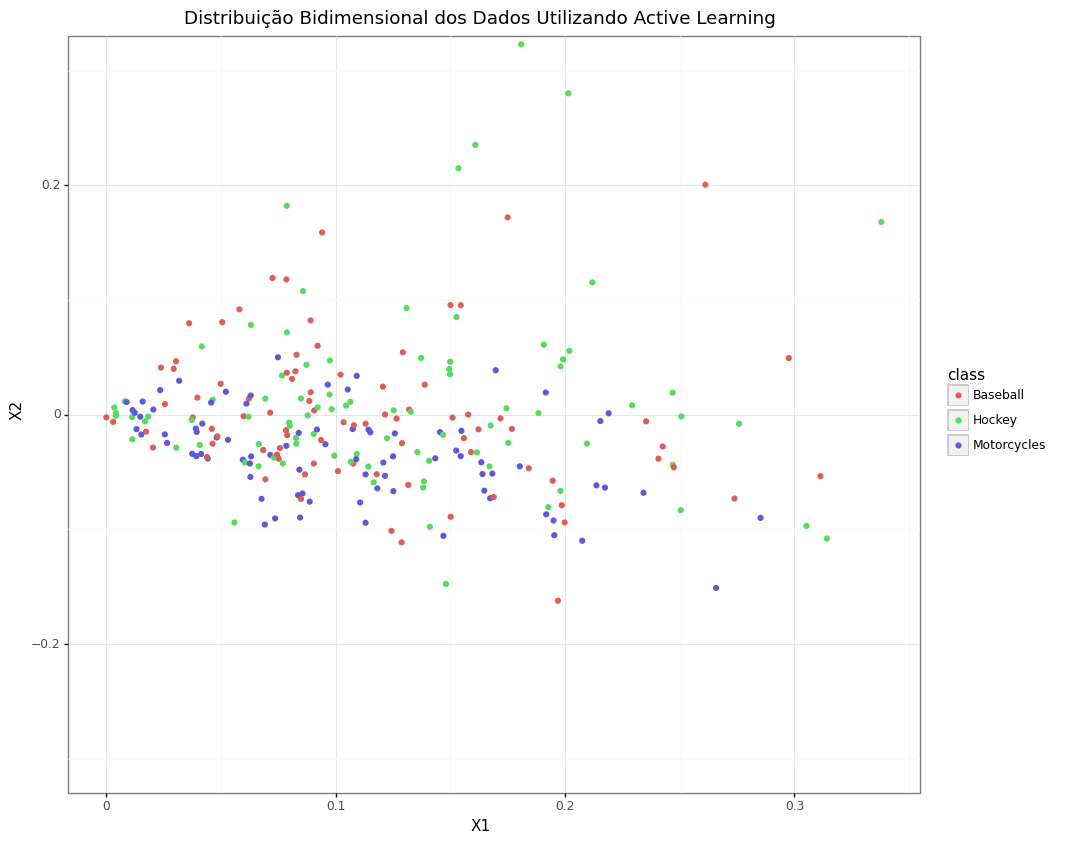

In [19]:
plot_dimensionality_reduction_distribution(X_list_active, y_list_active, 'Distribuição Bidimensional dos Dados Utilizando Active Learning')

Vamos repetir o processo utilizando instâncias aleatórias

In [20]:
# 35 amostras de 5 instâncias  para serem rotuladas 
N_AMOSTRAS = 35 
N_INSTANCES = 5
performance_history_random = [first_accuracy]

df_pool_random = df_pool.copy().reset_index(drop=True)

X_list_random = X_list_base.copy()
y_list_random = y_list_base.copy()

for index in range(N_AMOSTRAS):
    np.random.seed(0)
       
    new_index = list(np.random.randint(low=0, high=df_pool_random.shape[0], size= N_INSTANCES))
    new_text = df_pool_random.loc[new_index].text_clean
    X_list_random += new_text.tolist()
    y_list_random += df_pool_random.loc[new_index].target.tolist()
    
    df_pool_random.drop(new_index, inplace=True)
    df_pool_random.reset_index(drop=True, inplace=True)
    
    model_acc = clone(model, safe=True)
    model_acc.fit(X_list_random, y_list_random)
    score_test = model_acc.score(X_test, y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=(index + 1) * N_INSTANCES, acc=score_test))
    performance_history_random.append(score_test)

Accuracy after query 5: 0.6551
Accuracy after query 10: 0.6863
Accuracy after query 15: 0.6594
Accuracy after query 20: 0.6828
Accuracy after query 25: 0.7114
Accuracy after query 30: 0.7158
Accuracy after query 35: 0.7383
Accuracy after query 40: 0.7383
Accuracy after query 45: 0.7288
Accuracy after query 50: 0.7340
Accuracy after query 55: 0.7166
Accuracy after query 60: 0.7028
Accuracy after query 65: 0.7296
Accuracy after query 70: 0.7305
Accuracy after query 75: 0.7201
Accuracy after query 80: 0.7114
Accuracy after query 85: 0.7114
Accuracy after query 90: 0.7088
Accuracy after query 95: 0.7158
Accuracy after query 100: 0.7253
Accuracy after query 105: 0.7357
Accuracy after query 110: 0.7357
Accuracy after query 115: 0.7392
Accuracy after query 120: 0.7574
Accuracy after query 125: 0.7678
Accuracy after query 130: 0.7574
Accuracy after query 135: 0.7626
Accuracy after query 140: 0.7721
Accuracy after query 145: 0.7834
Accuracy after query 150: 0.7868
Accuracy after query 155: 0.79

Analisando a distribuição das instâncias após as escolhas aleatórias

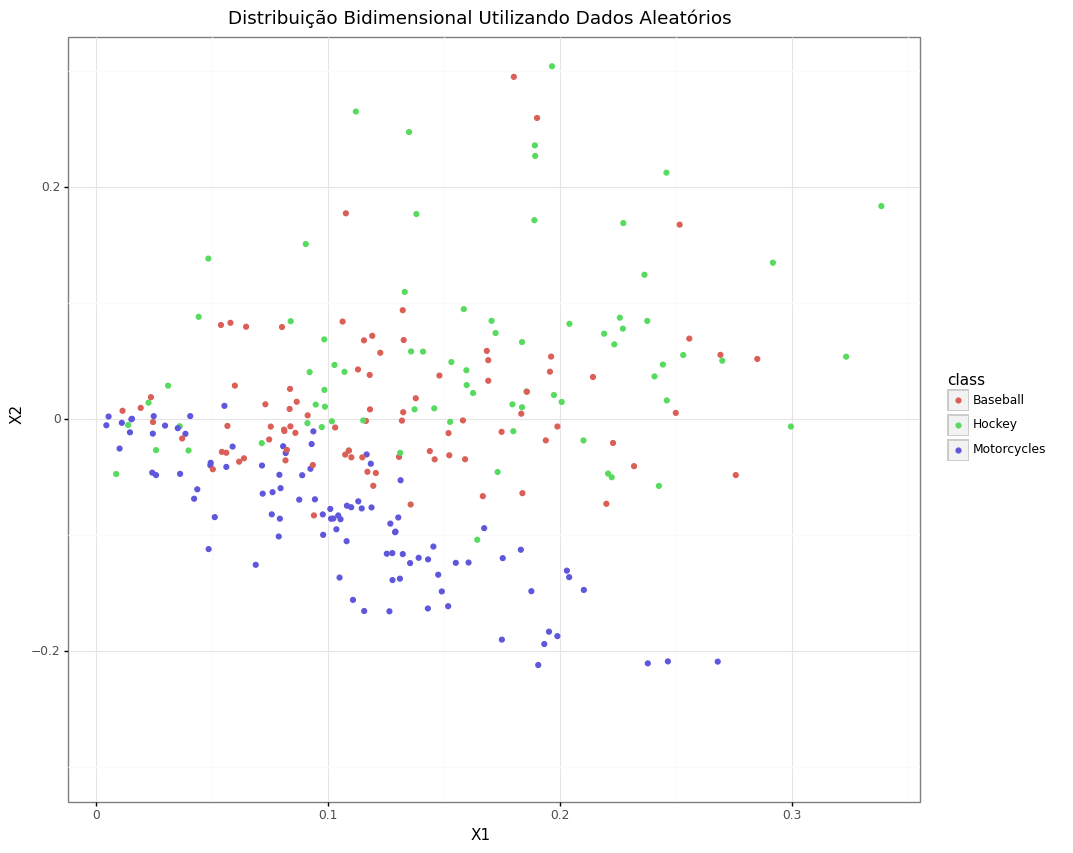

In [21]:
plot_dimensionality_reduction_distribution(X_list_random, y_list_random, 'Distribuição Bidimensional Utilizando Dados Aleatórios')

Vamos agora plotar a distribuição dos dados brutos em uma espaço vetorial bidimensional. Assim, teremos uma ideia de onde estão cada classe e onde é o limite de decisão. 

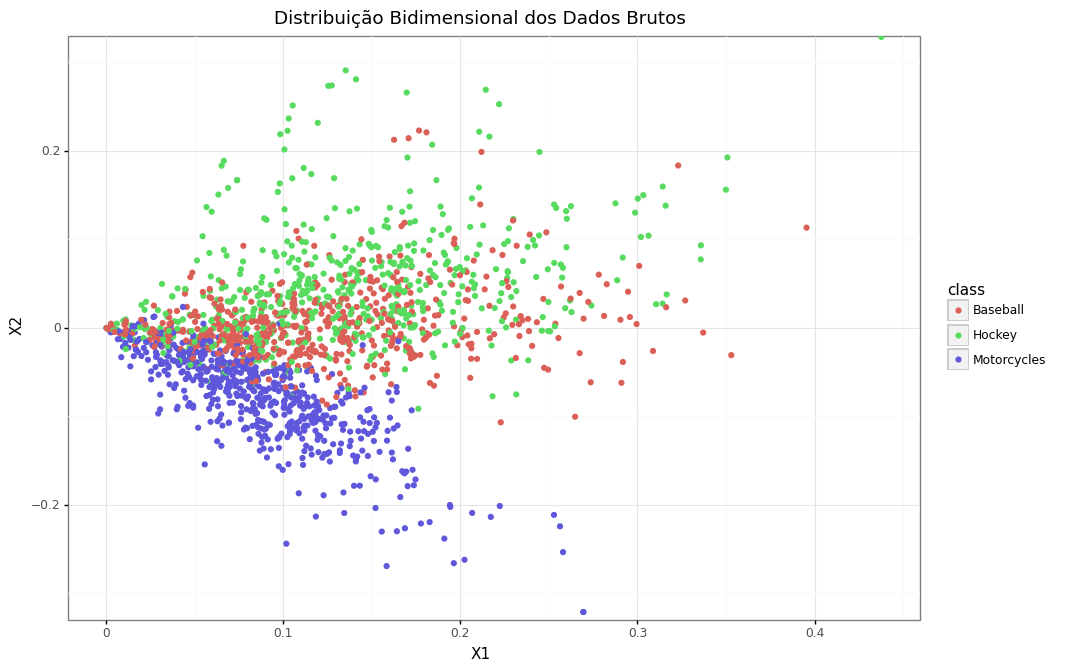

In [22]:
plot_dimensionality_reduction_distribution(raw_data.text_clean, raw_data.target, 'Distribuição Bidimensional dos Dados Brutos')

Podemos ver nos gráficos abaixo que utilizando a técnica de Active Learning, os dados estão mais concentrados onde é o limite de decisão. As instâncias aleatórias estão mais espalhadas no espaço bidimensional.

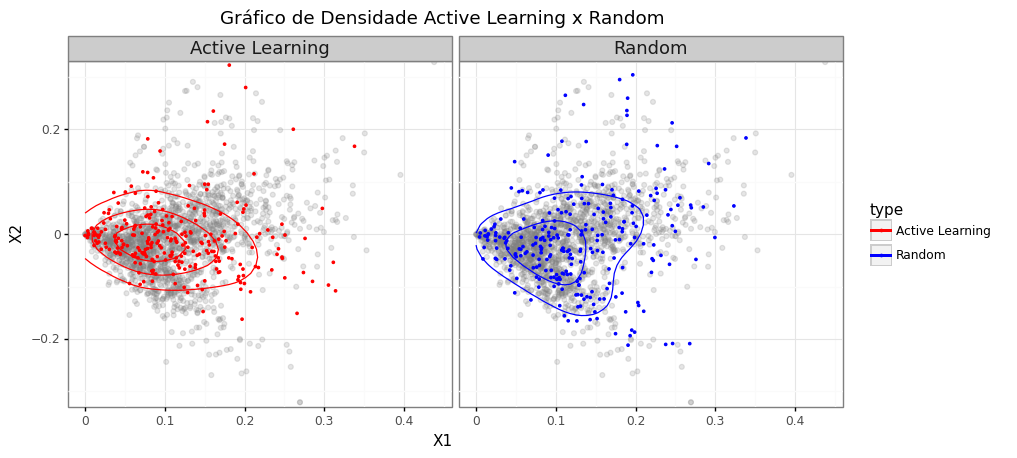

In [23]:
plot_density_distribution(raw_data.text_clean, X_list_active, X_list_random)

No gráfico abaixo, podemos ver a relação das amostras (cada uma possui 5 instâncias) em relação a acurácia do classificador. É observado que utilizando a técnica active learning, tivemos uma performance melhor em relação as instâncias escolhidas aleatoriamente.

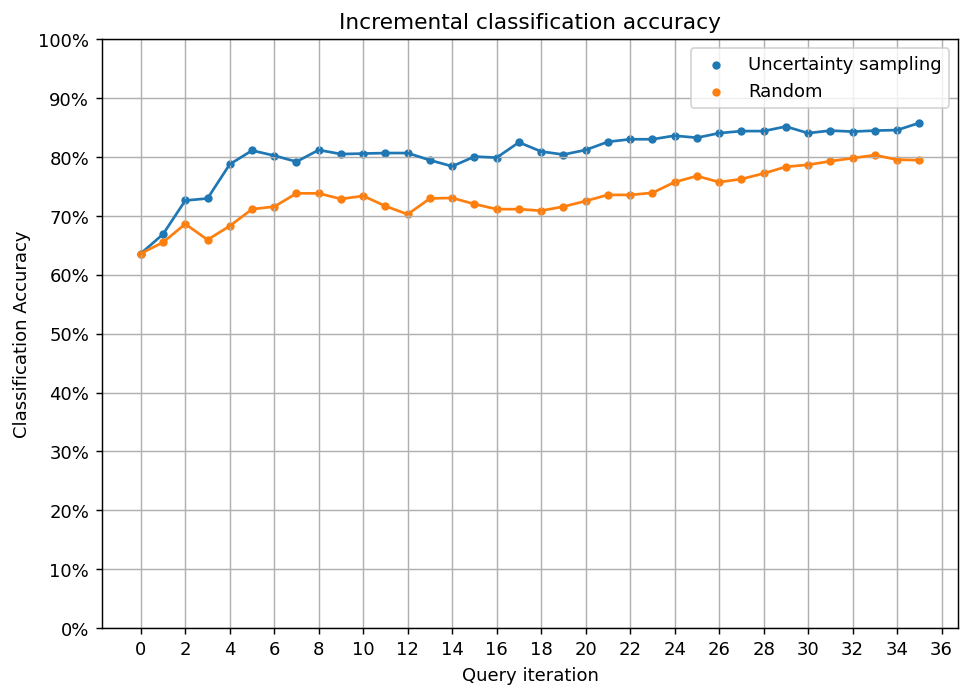

In [24]:
plot_performance(performance_history_random, performance_history_active)